## 0. before work

```
you must run ../data_prepare/data_prepare.ipynb to create rec dataset firstly
and then run this train file
```

## 1. import package and set global var

In [1]:
import mxnet as mx
from mxnet import gluon, image, autograd, nd
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection
from mxnet import metric
from mxnet.gluon import model_zoo

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time

import sys
sys.path.append("../")
from utils.utils import show_9_images, show_images, mkdir_if_not_exist, evaluate_MAP, draw_ROC

# dataset root dir
coins_root = "../dataset/"
sdl_root = coins_root + "sdl-coins/"
swiss_root = coins_root + "swiss-coins/"

data_shape = (3, 256, 256)
batch_size = 4
#mean = np.array([ 167.02477919,  157.20263027,  140.25492473])
#std = np.array([ 46.06696734,  47.12624331,  50.81295717])
rgb_mean = np.array([123, 117, 104])
std = np.array([58.395, 57.12, 57.375])

ctx = mx.gpu(0)
resize = (data_shape[1], data_shape[2])

In [3]:
?? image.CreateDetAugmenter

## 2. load data and plot data
```
ImageDetIter will call CreateDetAugmenter
if mean==True, it will sub defualt mean
if std==True, it will div default std

both mean and std can not set to False.

or you can cal them and set them as np.array([r, g, b])

在数据中加入rand_crop，添加多尺度信息
```

In [2]:
def get_iterators(rec_prefix, data_shape, batch_size):
    class_names = ['1yuan', '0.5yuan']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix + '_train.rec',
        path_imgidx=rec_prefix + '_train.idx',
        shuffle=True,
        mean=True,
        std=True,
        rand_crop=1,
        rand_gray=0.2,
        rand_mirror=True,
        rand_pad=0.4,
        pad_val=(rgb_mean[0], rgb_mean[1], rgb_mean[2]),
        min_object_covered=0.95,
        max_attempts=200,
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05,
        aspect_ratio_range=(0.5, 2),
        pca_noise=0.01,
    )
    
    valid_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix+'_val.rec',
        shuffle=False,
        mean=True,
        std=True
    )
    
    return train_iter, valid_iter, class_names, num_class

rec_prefix = sdl_root+"rec/sdl_" + str(resize[0]) + "_" + str(resize[1])
train_data, valid_data, class_names, num_class = get_iterators(rec_prefix, data_shape, batch_size)
    

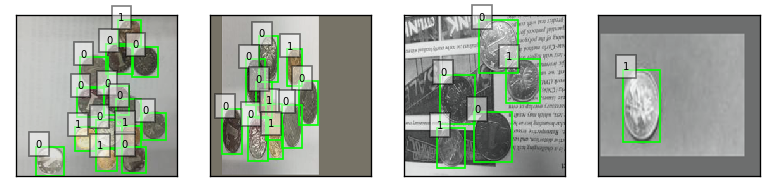

(4L, 14L, 5L)


In [3]:
"""
data plot
"""
mpl.rcParams['figure.dpi'] = 120

train_data.reset()
batch = train_data.next()
images = batch.data[0][:4]
labels = batch.label[0][:4]

show_images(images.asnumpy(), labels.asnumpy(), rgb_mean, std, show_text=True, fontsize=6, MN=(2, 4))
#show_9_images(images.asnumpy(), labels, rgb_mean)
print labels.shape

## 3. model define

In [4]:
"""
model define
"""
from mxnet.gluon.model_zoo.vision import *

def get_BodyNet(BaseModel, num_layers, ctx, pretrained=True):
    bose_model = BaseModel(pretrained=pretrained, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(bose_model.features[:num_layers]))
    return net

BaseModels = {'vgg11bn': (model_zoo.vision.vgg11_bn, 21), 
              'alexnet': (model_zoo.vision.alexnet, -1),
              'mobilenet_1_0': (model_zoo.vision.mobilenet1_0, 33)}

def down_sample(num_filter):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filter))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def class_predictor(num_class, num_anchors):
    return nn.Conv2D(num_anchors * (num_class + 1), kernel_size=3, strides=1, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, strides=1, padding=1)

class SSD(nn.HybridBlock):
    def __init__(self, num_class, sizes_list, ratios_list, ctx, verbose=False, body_net_args=['vgg11bn', 21, True],**kwargs):
        """
        body_net_args: [BaseModel, num_layers, pretrain]
        """
        super(SSD, self).__init__(**kwargs)
        self.num_class = num_class
        self.sizes_list = sizes_list
        self.ratios_list = ratios_list
        self.num_anchors = num_anchors = (len(sizes_list[0]) + len(ratios_list[0]) - 1)
        self.verbose = verbose
        
        with self.name_scope():
            # part 1
            if isinstance(body_net_args[0], str):
                BaseModel, num_layers = BaseModels[body_net_args[0]]
            else:
                BaseModel, num_layers = body_net_args[0], -1
            pretrain = True
            if len(body_net_args) >= 2:
                num_layers = body_net_args[1]
            if len(body_net_args) >= 3:
                pretrain = body_net_args[2]
            self.body = get_BodyNet(BaseModel, num_layers, ctx, pretrain)
            if pretrain == False:
                self.body.initialize(ctx=ctx)

            # part 2
            self.downsamples = nn.HybridSequential()
            for _ in range(len(sizes_list) - 2):
                self.downsamples.add(down_sample(128))

            # part 3
            self.class_predictors = nn.HybridSequential()
            self.box_predictors = nn.HybridSequential()
            for _ in range(len(sizes_list)):
                self.class_predictors.add(class_predictor(num_class, num_anchors))
                self.box_predictors.add(box_predictor(num_anchors))
                
            self.downsamples.initialize(ctx=ctx)
            self.class_predictors.initialize(ctx=ctx)
            self.box_predictors.initialize(ctx=ctx)
            
    def hybrid_forward(self, F, x):
        x = self.body(x)
        cls_preds = []
        box_preds = []
        anchors = []
        for i in range(len(self.sizes_list)):
            cls_preds.append((self.class_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            box_preds.append((self.box_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            anchors.append(MultiBoxPrior(x, sizes=self.sizes_list[i], ratios=self.ratios_list[i]))

            if self.verbose:
                print "predict scale", i, x.shape, 'with', anchors[-1].shape, 'anchors'

            if i < len(self.sizes_list) - 2:
                x = self.downsamples[i](x)
            elif i == len(self.sizes_list) - 2:
                x = F.Pooling(x, global_pool=True, pool_type='max', kernel=(x.shape[2], x.shape[3]))
        cls_preds = nd.concat(*cls_preds, dim=1).reshape((0, -1, num_class+1))
        box_preds = nd.concat(*box_preds, dim=1)
        anchors = nd.concat(*anchors, dim=1)
        return anchors, box_preds, cls_preds

sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
# sizes_list = [[ 0.10416667 ,0.17361111], [0.18624024, 0.34354575], [.37,.619],
#                       [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*len(sizes_list)

In [5]:
import time
net = SSD(2, sizes_list, ratios_list, ctx=mx.cpu(), verbose=True, prefix="ssd_")
print net
#net.initialize()
tic = time.time()
anchors, box_preds, cls_preds = net(batch.data[0])
print time.time() - tic
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, batch.label[0], cls_preds.transpose(axes=(0, 2, 1)))
print cls_labels.shape, cls_preds.shape, box_offset.shape, box_mask.shape

SSD(
  (downsamples): HybridSequential(
    (0): HybridSequential(
      (0): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(fix_gamma=False, eps=1e-05, momentum=0.9, axis=1, in_channels=128)
      (2): Activation(relu)
      (3): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(fix_gamma=False, eps=1e-05, momentum=0.9, axis=1, in_channels=128)
      (5): Activation(relu)
      (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    )
    (1): HybridSequential(
      (0): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(fix_gamma=False, eps=1e-05, momentum=0.9, axis=1, in_channels=128)
      (2): Activation(relu)
      (3): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(fix_gamma=False, eps=1e-05, momentum=0.9, axis=1, in_channels=128)
      (5): Activation(relu)
      (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(

# 4. loss define

In [6]:
"""
loss define
"""
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gama=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self.alpha = alpha
        self.gama = gama
        self.axis = axis
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, y, label):
        y = F.softmax(y)
        py = y.pick(label, axis=self.axis, keepdims=True)
        loss = - (self.alpha * ((1 - py) ** self.gama)) * py.log()
        return loss.mean(axis=self.batch_axis, exclude=True)
    
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, y, label, mask):
        loss = F.smooth_l1((y - label) * mask, scalar=1.0)
        return loss.mean(axis=self.batch_axis, exclude=True)
    
cls_loss = FocalLoss()
cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
#cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
box_loss = SmoothL1Loss()

# 5. train and plot result

In [7]:
"""
train net
"""

def evaluate_acc(data_iter, ctx):
    data_iter.reset()
    box_metric = metric.MAE()
    outs, labels = None, None
    for i, batch in enumerate(data_iter):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        anchors, box_preds, cls_preds = net(data)
        box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)),
                                                                  negative_mining_ratio=3.0)#, overlap_threshold=0.75)
        box_metric.update([box_offset], [box_preds * box_mask])
        
        cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
        out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
        if outs is None:
            outs = out
            labels = label
        else:
            outs = nd.concat(outs, out, dim=0)
            labels = nd.concat(labels, label, dim=0)
    AP = evaluate_MAP(outs, labels)
    return AP, box_metric
        
info = {"train_ap": [], "valid_ap": [], "loss": []}
def train(net, start_epoch, end_epoch, trainer=None):
    if trainer is None:
        trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5, 'wd': 5e-4})
    box_metric = metric.MAE()
    
    for e in range(start_epoch, end_epoch):
        train_data.reset()
        box_metric.reset()
        tic = time.time()
        _loss = [0,0]
        if e == 100 or e == 150 or e==180:
#         if e == 150 or e==180:
            trainer.set_learning_rate(trainer.learning_rate * 0.5)
            
        outs, labels = None, None
        for i, batch in enumerate(train_data):
            data = batch.data[0].as_in_context(ctx)
            label = batch.label[0].as_in_context(ctx)
            with autograd.record():
                anchors, box_preds, cls_preds = net(data)
                box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)),
                                                                  negative_mining_ratio=3.0)#, overlap_threshold=0.75)
                loss1 = cls_loss(cls_preds, cls_labels)
                loss2 = box_loss(box_preds, box_offset, box_mask)
                loss = loss1 + loss2
            loss.backward()
            trainer.step(data.shape[0])
            _loss[0] += nd.mean(loss1).asscalar()
            _loss[1] += nd.mean(loss2).asscalar()
            
            cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
            out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
            if outs is None:
                outs = out
                labels = label
            else:
                outs = nd.concat(outs, out, dim=0)
                labels = nd.concat(labels, label, dim=0)
            
            box_metric.update([box_offset], [box_preds * box_mask])
        
        train_AP = evaluate_MAP(outs, labels)
        valid_AP, val_box_metric = evaluate_acc(valid_data, ctx)
        info["train_ap"].append(train_AP)
        info["valid_ap"].append(valid_AP)
        info["loss"].append(_loss)
        
        if (e+1) % 10 == 0:
            print "epoch: %d time: %.2f loss: %.4f, %.4f lr: %.4f" % (e, time.time() - tic,_loss[0], _loss[1], trainer.learning_rate),
            print "train mae: %.4f AP: %.4f" % (box_metric.get()[1], train_AP),
            print "valid mae: %.4f AP: %.4f" % (val_box_metric.get()[1], valid_AP)

In [8]:
def plot_acc(info, x_range=(0, -1)):
    def plot(key, range_x):
        i, j = range_x
        plt.plot(range(len(info[key][i:j])), info[key][i:j], label=key)

    info["loss"] = np.array(info["loss"])
    info["loss1"] = info["loss"][:, 0]
    info["loss2"] = info["loss"][:, 1]

    plt.figure(figsize=(12, 4))   # (w, h)
    plt.subplot(121)
    plot("train_ap", x_range)
    plot("valid_ap", x_range)
    plt.legend(loc="upper right")
    plt.subplot(122)
    plot("loss1", x_range)
    plot("loss2", x_range)
    plt.legend(loc="upper right")
    
def plot_ROC(train_data, net):
    train_data.reset()
    outs = None
    labels = None
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        anchors, box_preds, cls_preds = net(data)
        cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode="channel")
        out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
        if outs is None:
            outs = out
            labels = label
        else:
            outs = nd.concat(*[outs, out], dim=0)
            labels = nd.concat(*[labels, label], dim=0)

    print outs.shape
    print labels.shape
    print evaluate_MAP(outs, labels)
    draw_ROC(outs, labels, verbose=True)

# 6. multi model result

## 6. ['mobilenet_1_0', 33, False]
Memory 989MiB

In [10]:
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=['mobilenet_1_0', 33, False])
train(net, 0, 200)

epoch: 9 time: 2.04 loss: 1.1013, 0.1756 lr: 0.5000 train mae: 0.0127 AP: 0.4980 valid mae: 0.0138 AP: 0.4999
epoch: 19 time: 2.06 loss: 1.0213, 0.1628 lr: 0.5000 train mae: 0.0130 AP: 0.6493 valid mae: 0.0118 AP: 0.6492
epoch: 29 time: 2.05 loss: 0.8899, 0.1258 lr: 0.5000 train mae: 0.0103 AP: 0.6262 valid mae: 0.0104 AP: 0.6639
epoch: 39 time: 2.09 loss: 0.8032, 0.1187 lr: 0.5000 train mae: 0.0097 AP: 0.6357 valid mae: 0.0098 AP: 0.7545
epoch: 49 time: 2.11 loss: 0.6611, 0.0948 lr: 0.5000 train mae: 0.0083 AP: 0.7005 valid mae: 0.0093 AP: 0.8021
epoch: 59 time: 2.12 loss: 0.7369, 0.1046 lr: 0.5000 train mae: 0.0093 AP: 0.6848 valid mae: 0.0091 AP: 0.7603
epoch: 69 time: 2.02 loss: 0.6627, 0.0902 lr: 0.5000 train mae: 0.0082 AP: 0.7260 valid mae: 0.0095 AP: 0.7030
epoch: 79 time: 2.03 loss: 0.6651, 0.0883 lr: 0.5000 train mae: 0.0083 AP: 0.7265 valid mae: 0.0108 AP: 0.6646
epoch: 89 time: 2.11 loss: 0.7412, 0.0941 lr: 0.5000 train mae: 0.0093 AP: 0.7555 valid mae: 0.0106 AP: 0.5858
ep

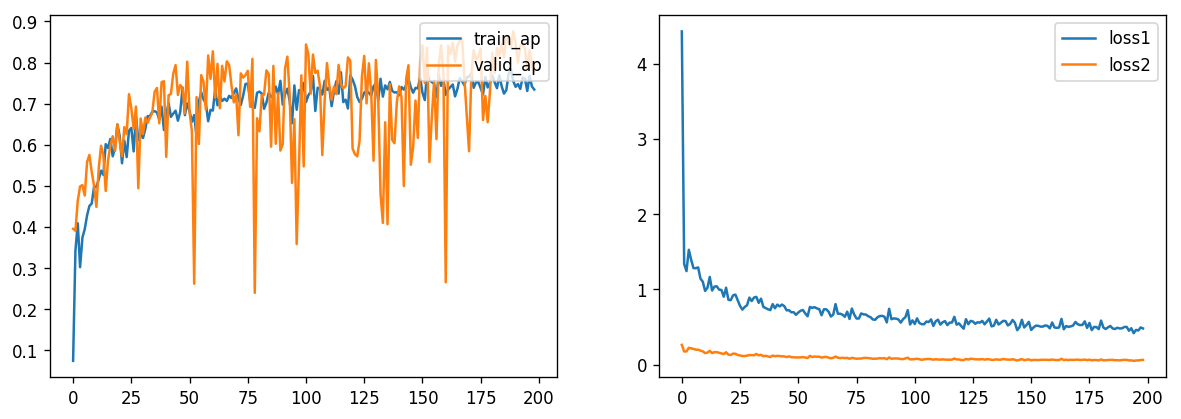

In [11]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.72257578989


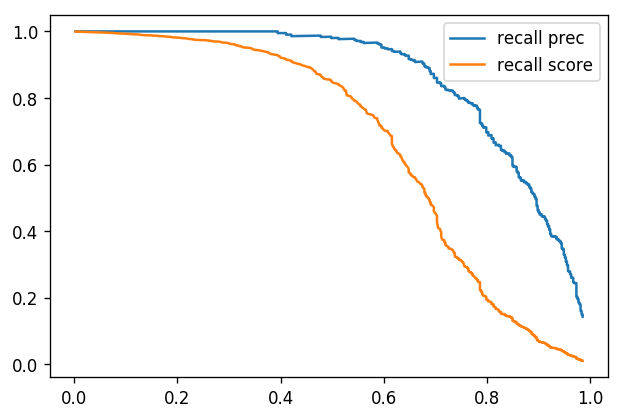

In [12]:
plot_ROC(train_data, net)

## 6.1 [resnet18_v2, 7, True]

In [15]:
del net, info
info = {"train_ap": [], "valid_ap": [], "loss": []}
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=[resnet18_v2, 7, True])
train(net, 0, 200)

epoch: 9 time: 2.07 loss: 0.7540, 0.1301 lr: 0.5000 train mae: 0.0106 AP: 0.6870 valid mae: 0.0095 AP: 0.8247
epoch: 19 time: 2.07 loss: 0.6435, 0.0978 lr: 0.5000 train mae: 0.0089 AP: 0.7341 valid mae: 0.0078 AP: 0.8426
epoch: 29 time: 2.09 loss: 0.6067, 0.0863 lr: 0.5000 train mae: 0.0084 AP: 0.7356 valid mae: 0.0069 AP: 0.8269
epoch: 39 time: 2.01 loss: 0.5957, 0.0784 lr: 0.5000 train mae: 0.0078 AP: 0.7109 valid mae: 0.0064 AP: 0.7715
epoch: 49 time: 1.99 loss: 0.4821, 0.0601 lr: 0.5000 train mae: 0.0063 AP: 0.7469 valid mae: 0.0058 AP: 0.8429
epoch: 59 time: 1.98 loss: 0.4552, 0.0550 lr: 0.5000 train mae: 0.0058 AP: 0.7449 valid mae: 0.0057 AP: 0.8712
epoch: 69 time: 2.05 loss: 0.4682, 0.0570 lr: 0.5000 train mae: 0.0062 AP: 0.7546 valid mae: 0.0052 AP: 0.8208
epoch: 79 time: 2.05 loss: 0.4828, 0.0588 lr: 0.5000 train mae: 0.0063 AP: 0.7222 valid mae: 0.0055 AP: 0.8438
epoch: 89 time: 2.04 loss: 0.4091, 0.0471 lr: 0.5000 train mae: 0.0053 AP: 0.7586 valid mae: 0.0052 AP: 0.8893
ep

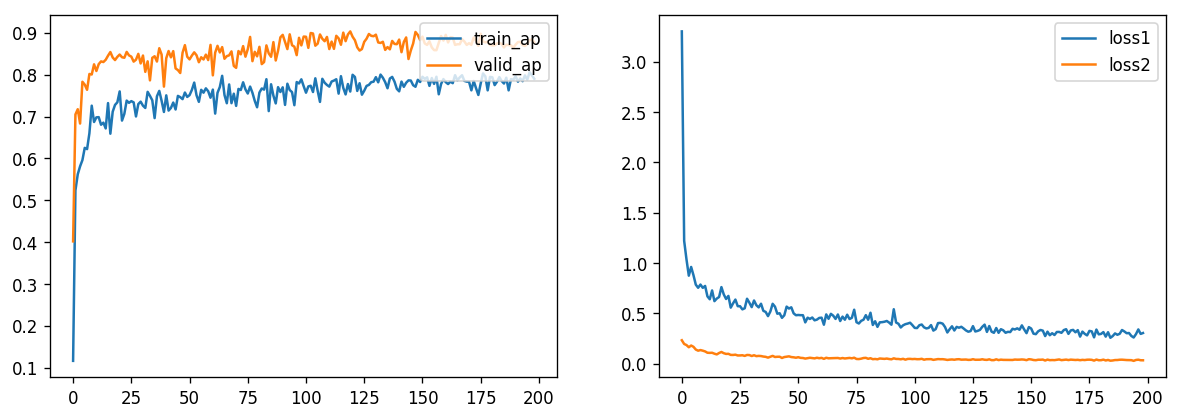

In [28]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.789556402923


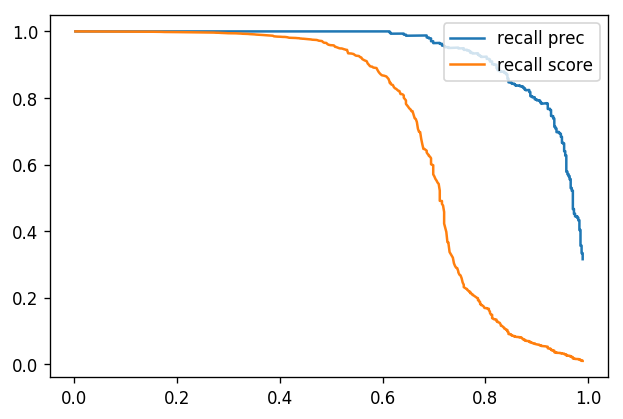

In [19]:
plot_ROC(train_data, net)

In [17]:
del net, info
info = {"train_ap": [], "valid_ap": [], "loss": []}
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=[resnet34_v2, 7, True])
train(net, 0, 200)

epoch: 9 time: 2.15 loss: 0.7938, 0.1198 lr: 0.5000 train mae: 0.0100 AP: 0.6607 valid mae: 0.0087 AP: 0.7998
epoch: 19 time: 2.29 loss: 0.6041, 0.0866 lr: 0.5000 train mae: 0.0081 AP: 0.7313 valid mae: 0.0069 AP: 0.8094
epoch: 29 time: 2.10 loss: 0.4801, 0.0618 lr: 0.5000 train mae: 0.0066 AP: 0.7477 valid mae: 0.0062 AP: 0.8216
epoch: 39 time: 2.08 loss: 0.4209, 0.0548 lr: 0.5000 train mae: 0.0060 AP: 0.7742 valid mae: 0.0055 AP: 0.8155
epoch: 49 time: 2.11 loss: 0.4328, 0.0551 lr: 0.5000 train mae: 0.0062 AP: 0.7860 valid mae: 0.0059 AP: 0.8108
epoch: 59 time: 2.10 loss: 0.4161, 0.0532 lr: 0.5000 train mae: 0.0061 AP: 0.7770 valid mae: 0.0049 AP: 0.8768
epoch: 69 time: 2.14 loss: 0.3474, 0.0392 lr: 0.5000 train mae: 0.0049 AP: 0.7931 valid mae: 0.0046 AP: 0.8782
epoch: 79 time: 2.12 loss: 0.3540, 0.0447 lr: 0.5000 train mae: 0.0053 AP: 0.7750 valid mae: 0.0045 AP: 0.8967
epoch: 89 time: 2.19 loss: 0.3562, 0.0436 lr: 0.5000 train mae: 0.0051 AP: 0.7795 valid mae: 0.0042 AP: 0.9015
ep

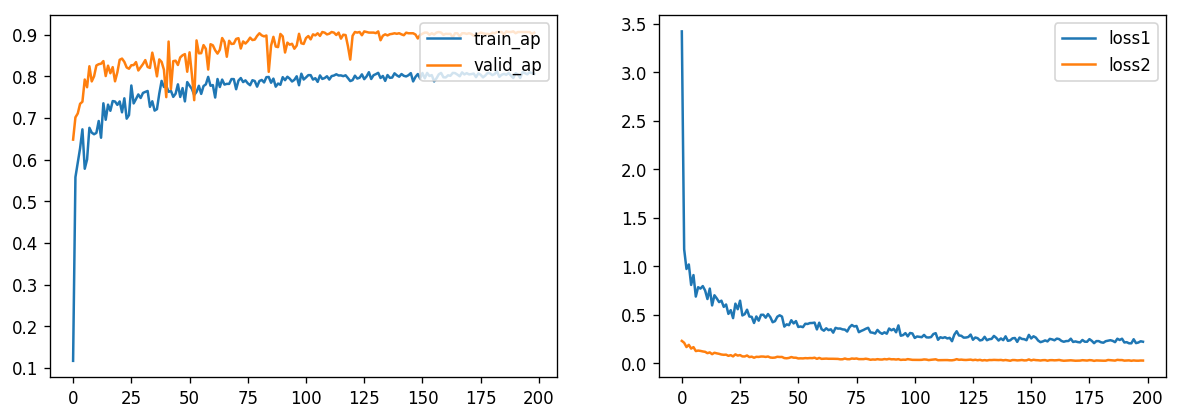

In [18]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.808806209489


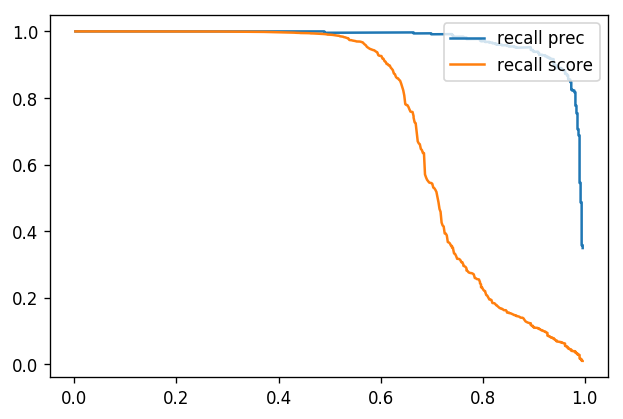

In [19]:
plot_ROC(train_data, net)

In [20]:
del net, info
info = {"train_ap": [], "valid_ap": [], "loss": []}
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=[resnet50_v2, 7, True])
train(net, 0, 200)

epoch: 9 time: 2.51 loss: 0.8322, 0.1513 lr: 0.5000 train mae: 0.0116 AP: 0.6298 valid mae: 0.0112 AP: 0.7547
epoch: 19 time: 2.53 loss: 0.7465, 0.1100 lr: 0.5000 train mae: 0.0097 AP: 0.7320 valid mae: 0.0082 AP: 0.8117
epoch: 29 time: 2.61 loss: 0.5966, 0.0829 lr: 0.5000 train mae: 0.0077 AP: 0.7250 valid mae: 0.0072 AP: 0.8073
epoch: 39 time: 2.56 loss: 0.5357, 0.0758 lr: 0.5000 train mae: 0.0071 AP: 0.7057 valid mae: 0.0073 AP: 0.7979
epoch: 49 time: 2.57 loss: 0.5535, 0.0686 lr: 0.5000 train mae: 0.0069 AP: 0.7063 valid mae: 0.0061 AP: 0.8440
epoch: 59 time: 2.71 loss: 0.4906, 0.0574 lr: 0.5000 train mae: 0.0062 AP: 0.7633 valid mae: 0.0059 AP: 0.8017
epoch: 69 time: 2.59 loss: 0.5094, 0.0620 lr: 0.5000 train mae: 0.0066 AP: 0.7655 valid mae: 0.0063 AP: 0.8273
epoch: 79 time: 2.55 loss: 0.4320, 0.0509 lr: 0.5000 train mae: 0.0058 AP: 0.7844 valid mae: 0.0057 AP: 0.8057
epoch: 89 time: 2.52 loss: 0.4298, 0.0547 lr: 0.5000 train mae: 0.0059 AP: 0.7225 valid mae: 0.0051 AP: 0.8645
ep

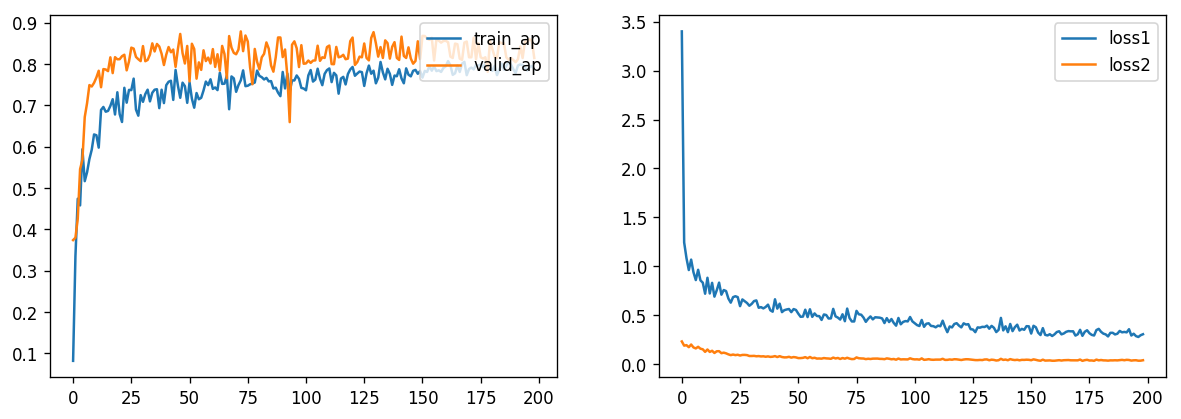

In [21]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.790411409102


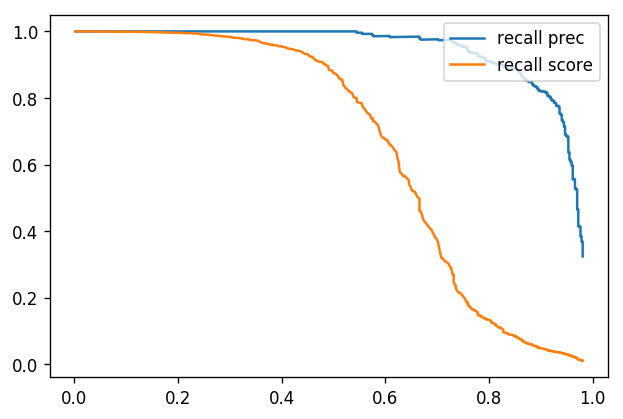

In [22]:
plot_ROC(train_data, net)

In [23]:
del net, info
info = {"train_ap": [], "valid_ap": [], "loss": []}
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=[resnet101_v1, 6, True])
train(net, 0, 200)

epoch: 9 time: 2.58 loss: 0.8261, 0.1465 lr: 0.5000 train mae: 0.0113 AP: 0.6257 valid mae: 0.0112 AP: 0.6549
epoch: 19 time: 2.81 loss: 0.6051, 0.0942 lr: 0.5000 train mae: 0.0082 AP: 0.7072 valid mae: 0.0081 AP: 0.8156
epoch: 29 time: 2.58 loss: 0.6519, 0.0955 lr: 0.5000 train mae: 0.0091 AP: 0.7405 valid mae: 0.0073 AP: 0.8222
epoch: 39 time: 2.55 loss: 0.5502, 0.0721 lr: 0.5000 train mae: 0.0070 AP: 0.7428 valid mae: 0.0064 AP: 0.8442
epoch: 49 time: 2.57 loss: 0.5949, 0.0725 lr: 0.5000 train mae: 0.0071 AP: 0.7267 valid mae: 0.0059 AP: 0.7966
epoch: 59 time: 2.57 loss: 0.4867, 0.0597 lr: 0.5000 train mae: 0.0066 AP: 0.7609 valid mae: 0.0054 AP: 0.8491
epoch: 69 time: 2.58 loss: 0.3723, 0.0444 lr: 0.5000 train mae: 0.0050 AP: 0.7616 valid mae: 0.0059 AP: 0.8444
epoch: 79 time: 2.65 loss: 0.4260, 0.0510 lr: 0.5000 train mae: 0.0057 AP: 0.7578 valid mae: 0.0056 AP: 0.8670
epoch: 89 time: 2.58 loss: 0.4688, 0.0547 lr: 0.5000 train mae: 0.0061 AP: 0.7637 valid mae: 0.0052 AP: 0.8739
ep

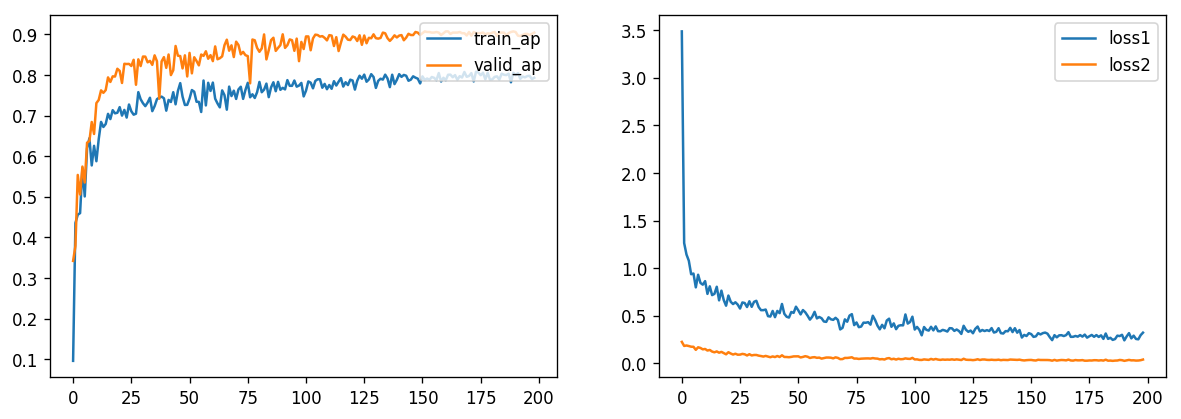

In [24]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.780634996665


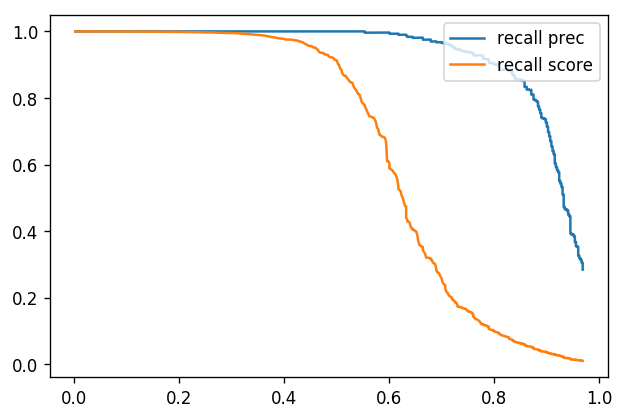

In [25]:
plot_ROC(train_data, net)

In [26]:
del net, info
info = {"train_ap": [], "valid_ap": [], "loss": []}
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=[resnet152_v1, 6, True])
train(net, 0, 200)

epoch: 9 time: 2.88 loss: 0.7442, 0.1230 lr: 0.5000 train mae: 0.0101 AP: 0.7011 valid mae: 0.0091 AP: 0.8289
epoch: 19 time: 2.88 loss: 0.6897, 0.1029 lr: 0.5000 train mae: 0.0093 AP: 0.7333 valid mae: 0.0067 AP: 0.8847
epoch: 29 time: 2.88 loss: 0.5508, 0.0708 lr: 0.5000 train mae: 0.0072 AP: 0.7573 valid mae: 0.0055 AP: 0.8446
epoch: 39 time: 3.08 loss: 0.4214, 0.0537 lr: 0.5000 train mae: 0.0059 AP: 0.7506 valid mae: 0.0050 AP: 0.8533
epoch: 49 time: 2.87 loss: 0.4799, 0.0578 lr: 0.5000 train mae: 0.0066 AP: 0.7775 valid mae: 0.0044 AP: 0.8947
epoch: 59 time: 2.87 loss: 0.4378, 0.0519 lr: 0.5000 train mae: 0.0061 AP: 0.7835 valid mae: 0.0050 AP: 0.8779
epoch: 69 time: 2.86 loss: 0.3708, 0.0406 lr: 0.5000 train mae: 0.0051 AP: 0.7990 valid mae: 0.0046 AP: 0.8913
epoch: 79 time: 2.89 loss: 0.3973, 0.0412 lr: 0.5000 train mae: 0.0052 AP: 0.7921 valid mae: 0.0049 AP: 0.8588
epoch: 89 time: 3.00 loss: 0.3107, 0.0341 lr: 0.5000 train mae: 0.0043 AP: 0.7954 valid mae: 0.0037 AP: 0.8857
ep

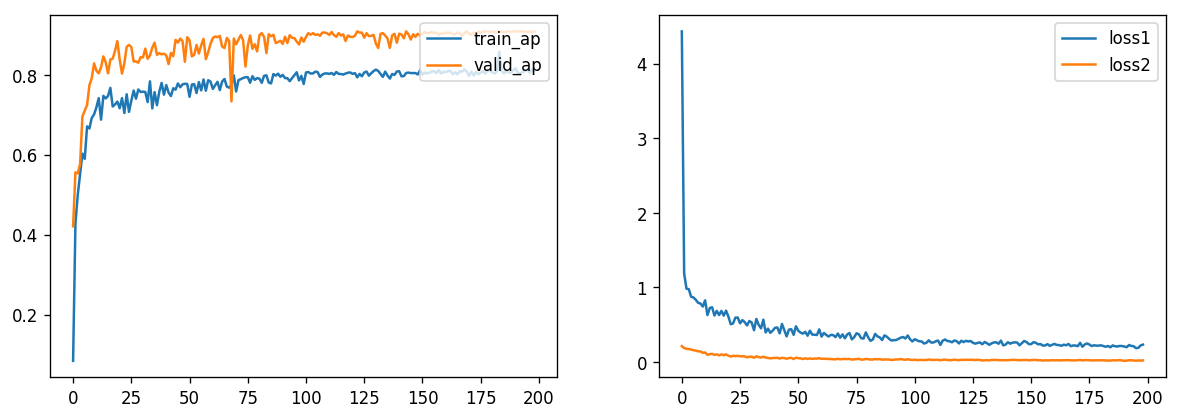

In [27]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.809724778146


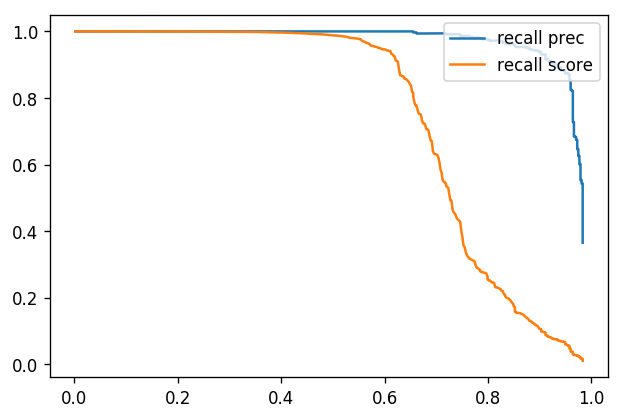

In [28]:
plot_ROC(train_data, net)

In [29]:
del net, info
info = {"train_ap": [], "valid_ap": [], "loss": []}
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=[densenet121, 7, True])
train(net, 0, 200)

epoch: 9 time: 2.74 loss: 0.7344, 0.1229 lr: 0.5000 train mae: 0.0100 AP: 0.6673 valid mae: 0.0089 AP: 0.7659
epoch: 19 time: 2.69 loss: 0.6187, 0.0896 lr: 0.5000 train mae: 0.0086 AP: 0.7382 valid mae: 0.0062 AP: 0.8311
epoch: 29 time: 2.71 loss: 0.4915, 0.0658 lr: 0.5000 train mae: 0.0068 AP: 0.7584 valid mae: 0.0060 AP: 0.8434
epoch: 39 time: 2.72 loss: 0.4721, 0.0640 lr: 0.5000 train mae: 0.0067 AP: 0.7307 valid mae: 0.0062 AP: 0.8326
epoch: 49 time: 2.71 loss: 0.3593, 0.0433 lr: 0.5000 train mae: 0.0048 AP: 0.7437 valid mae: 0.0047 AP: 0.8640
epoch: 59 time: 2.71 loss: 0.3410, 0.0468 lr: 0.5000 train mae: 0.0052 AP: 0.7635 valid mae: 0.0069 AP: 0.8765
epoch: 69 time: 2.70 loss: 0.2972, 0.0385 lr: 0.5000 train mae: 0.0044 AP: 0.7572 valid mae: 0.0047 AP: 0.8968
epoch: 79 time: 2.70 loss: 0.3715, 0.0424 lr: 0.5000 train mae: 0.0053 AP: 0.7915 valid mae: 0.0040 AP: 0.8699
epoch: 89 time: 2.72 loss: 0.3607, 0.0462 lr: 0.5000 train mae: 0.0053 AP: 0.7776 valid mae: 0.0040 AP: 0.8898
ep

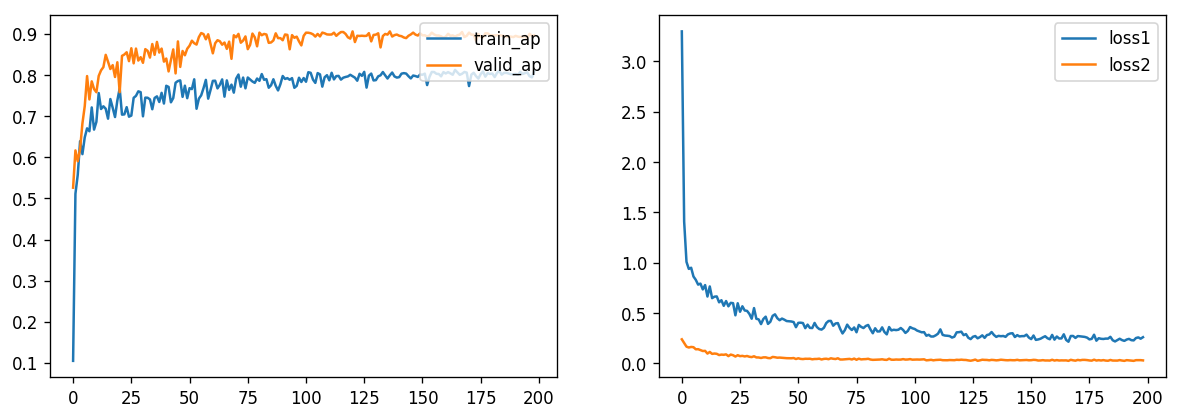

In [30]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.802152093303


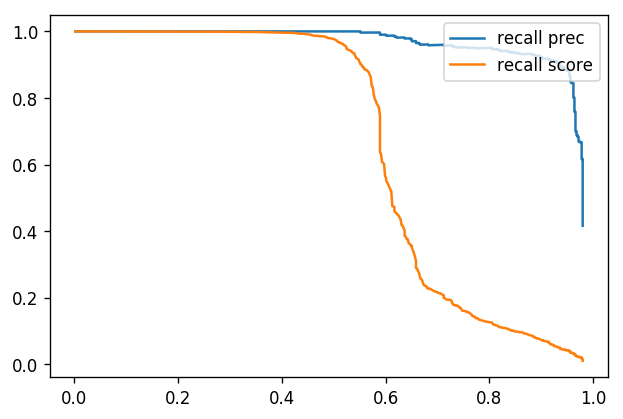

In [31]:
plot_ROC(train_data, net)

In [34]:
del net, info
info = {"train_ap": [], "valid_ap": [], "loss": []}
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=[densenet161, 7, True])
train(net, 0, 200)

epoch: 9 time: 3.47 loss: 0.7149, 0.1185 lr: 0.5000 train mae: 0.0098 AP: 0.6999 valid mae: 0.0095 AP: 0.7718
epoch: 19 time: 3.93 loss: 0.6855, 0.0963 lr: 0.5000 train mae: 0.0089 AP: 0.7361 valid mae: 0.0066 AP: 0.8268
epoch: 29 time: 4.18 loss: 0.4970, 0.0727 lr: 0.5000 train mae: 0.0072 AP: 0.7284 valid mae: 0.0063 AP: 0.8513
epoch: 39 time: 3.31 loss: 0.4460, 0.0562 lr: 0.5000 train mae: 0.0061 AP: 0.7467 valid mae: 0.0053 AP: 0.8390
epoch: 49 time: 3.29 loss: 0.4126, 0.0512 lr: 0.5000 train mae: 0.0055 AP: 0.7550 valid mae: 0.0045 AP: 0.8329
epoch: 59 time: 3.33 loss: 0.3906, 0.0509 lr: 0.5000 train mae: 0.0056 AP: 0.7504 valid mae: 0.0045 AP: 0.8661
epoch: 69 time: 3.34 loss: 0.3292, 0.0439 lr: 0.5000 train mae: 0.0049 AP: 0.7506 valid mae: 0.0042 AP: 0.8934
epoch: 79 time: 3.32 loss: 0.3729, 0.0435 lr: 0.5000 train mae: 0.0054 AP: 0.7959 valid mae: 0.0039 AP: 0.9046
epoch: 89 time: 3.30 loss: 0.3724, 0.0438 lr: 0.5000 train mae: 0.0051 AP: 0.7447 valid mae: 0.0059 AP: 0.8889
ep

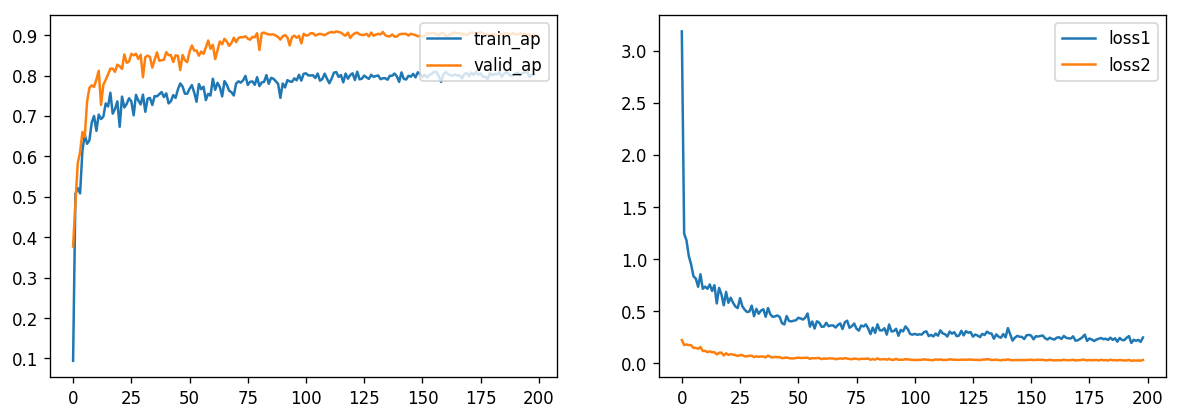

In [35]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.805844382272


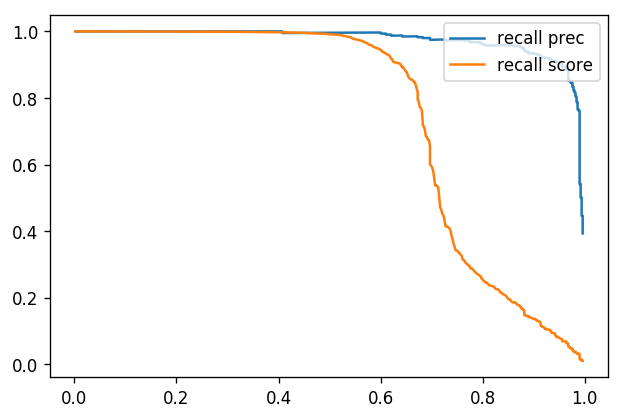

In [36]:
plot_ROC(train_data, net)

In [37]:
del net, info
info = {"train_ap": [], "valid_ap": [], "loss": []}
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=[densenet169, 7, True])
train(net, 0, 200)

epoch: 9 time: 3.03 loss: 0.7633, 0.1210 lr: 0.5000 train mae: 0.0101 AP: 0.7535 valid mae: 0.0095 AP: 0.7827
epoch: 19 time: 2.71 loss: 0.6782, 0.0954 lr: 0.5000 train mae: 0.0090 AP: 0.7590 valid mae: 0.0071 AP: 0.8204
epoch: 29 time: 2.71 loss: 0.5702, 0.0737 lr: 0.5000 train mae: 0.0075 AP: 0.7587 valid mae: 0.0074 AP: 0.8139
epoch: 39 time: 2.69 loss: 0.4315, 0.0548 lr: 0.5000 train mae: 0.0061 AP: 0.7749 valid mae: 0.0056 AP: 0.8637
epoch: 49 time: 2.68 loss: 0.4564, 0.0609 lr: 0.5000 train mae: 0.0067 AP: 0.7768 valid mae: 0.0053 AP: 0.8242
epoch: 59 time: 2.78 loss: 0.4610, 0.0512 lr: 0.5000 train mae: 0.0059 AP: 0.7825 valid mae: 0.0075 AP: 0.8611
epoch: 69 time: 2.76 loss: 0.3787, 0.0490 lr: 0.5000 train mae: 0.0057 AP: 0.7887 valid mae: 0.0046 AP: 0.8019
epoch: 79 time: 2.71 loss: 0.3442, 0.0424 lr: 0.5000 train mae: 0.0049 AP: 0.7630 valid mae: 0.0048 AP: 0.8311
epoch: 89 time: 2.69 loss: 0.3830, 0.0448 lr: 0.5000 train mae: 0.0053 AP: 0.7782 valid mae: 0.0040 AP: 0.8868
ep

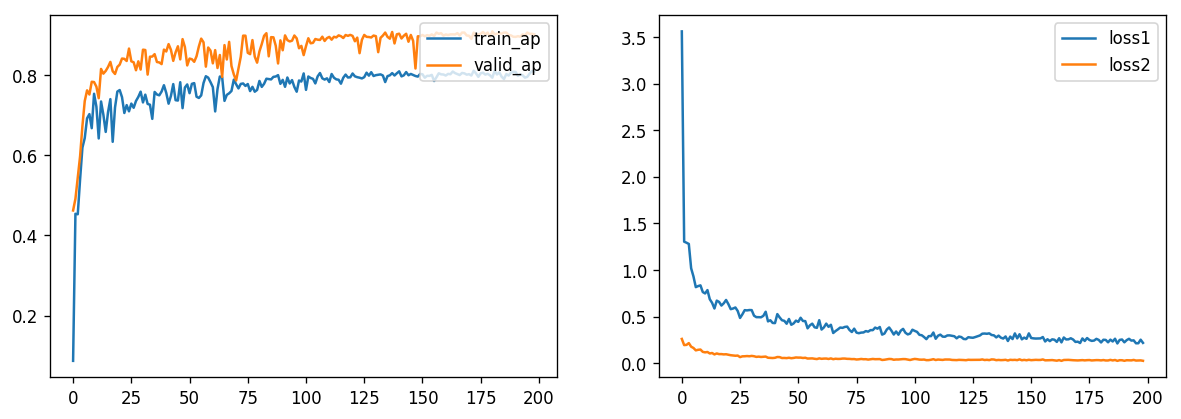

In [38]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.802790400184


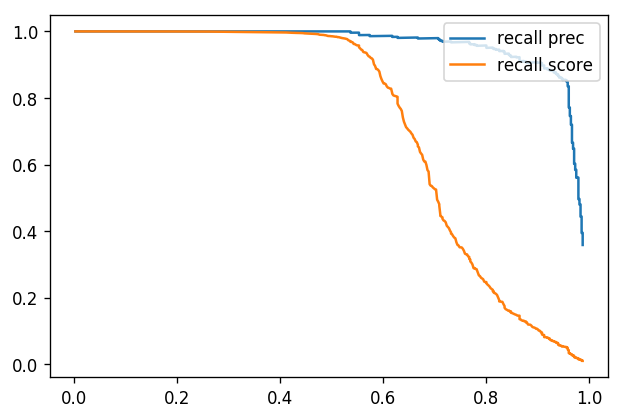

In [39]:
plot_ROC(train_data, net)

In [40]:
del net, info
info = {"train_ap": [], "valid_ap": [], "loss": []}
net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_", body_net_args=[densenet201, 7, True])
train(net, 0, 200)

epoch: 9 time: 2.79 loss: 0.8748, 0.1477 lr: 0.5000 train mae: 0.0118 AP: 0.7271 valid mae: 0.0105 AP: 0.7921
epoch: 19 time: 2.82 loss: 0.7140, 0.1059 lr: 0.5000 train mae: 0.0093 AP: 0.7148 valid mae: 0.0100 AP: 0.5965
epoch: 29 time: 2.80 loss: 0.5061, 0.0650 lr: 0.5000 train mae: 0.0067 AP: 0.7575 valid mae: 0.0064 AP: 0.8134
epoch: 39 time: 2.79 loss: 0.5087, 0.0639 lr: 0.5000 train mae: 0.0065 AP: 0.7638 valid mae: 0.0060 AP: 0.8400
epoch: 49 time: 2.75 loss: 0.4402, 0.0562 lr: 0.5000 train mae: 0.0061 AP: 0.7530 valid mae: 0.0051 AP: 0.8485
epoch: 59 time: 2.77 loss: 0.4447, 0.0582 lr: 0.5000 train mae: 0.0062 AP: 0.7492 valid mae: 0.0051 AP: 0.8697
epoch: 69 time: 2.77 loss: 0.3674, 0.0448 lr: 0.5000 train mae: 0.0054 AP: 0.7759 valid mae: 0.0044 AP: 0.8541
epoch: 79 time: 2.79 loss: 0.3452, 0.0403 lr: 0.5000 train mae: 0.0049 AP: 0.7859 valid mae: 0.0051 AP: 0.8934
epoch: 89 time: 2.85 loss: 0.3365, 0.0423 lr: 0.5000 train mae: 0.0047 AP: 0.7689 valid mae: 0.0065 AP: 0.7547
ep

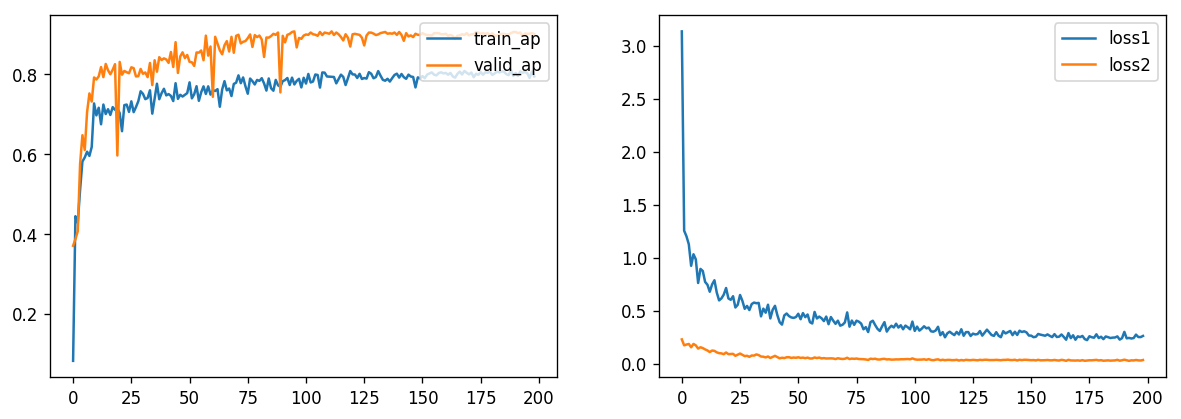

In [41]:
plot_acc(info)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.810343037416


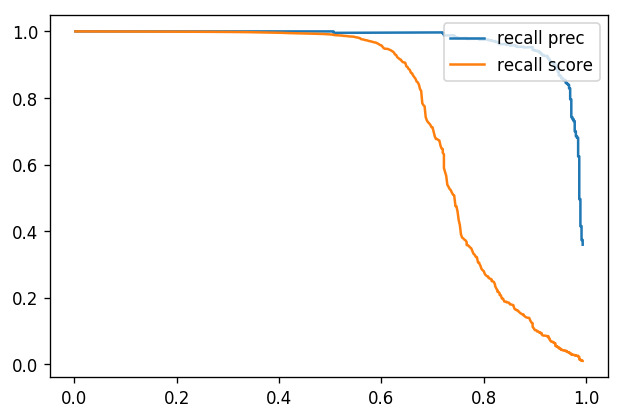

In [42]:
plot_ROC(train_data, net)

## 可视化测试结果

In [40]:
net = SSD(2, sizes_list, ratios_list, ctx=ctx, verbose=False, prefix="ssd_")
net.load_params("../models/sdl_coin_vgg11bn28_512x512_data_sizes.param", ctx=ctx)

(92L, 5444L, 6L)
(92L, 14L, 5L)
0.793113162437


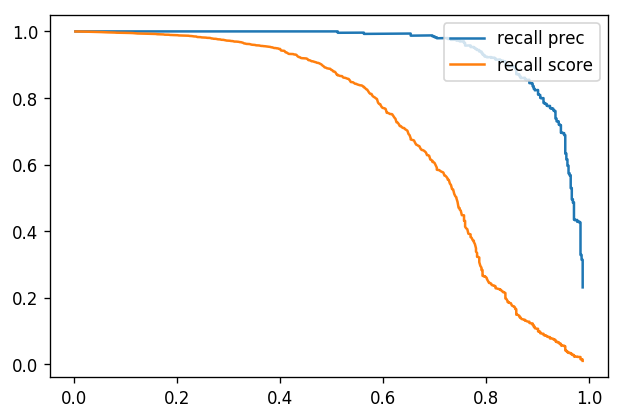

In [43]:
from utils.utils import find_best_score_th
score_th = find_best_score_th(outs.asnumpy(), labels.asnumpy())
print score_th

0.974642


In [43]:
valid_data = image.ImageDetIter(
    batch_size=batch_size, 
    data_shape=data_shape,
    path_imgrec=sdl_root+"rec/sdl"+'_val.rec',
    shuffle=False,
    mean=True,
    #std=True
)

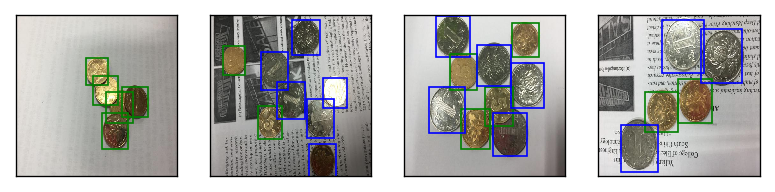

In [48]:
from utils.utils import show_det_results
from mxnet.contrib.ndarray import MultiBoxDetection

mpl.rcParams['figure.figsize'] = (6, 6)
try:
    batch = valid_data.next()
except Exception:
    valid_data.reset()
data = batch.data[0].as_in_context(ctx)
label = batch.label[0].as_in_context(ctx)
anchors, box_preds, cls_preds = net(data)
cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, 
                                                  cls_preds.transpose(axes=(0, 2, 1)), negative_mining_ratio=3)

imgs = (data.transpose((0, 2, 3, 1)).asnumpy() * std)+ rgb_mean
#plt.imshow(imgs[0] / 255)
show_det_results(imgs, out, threshold=0.33, show_text=False, MN=(2, 4))

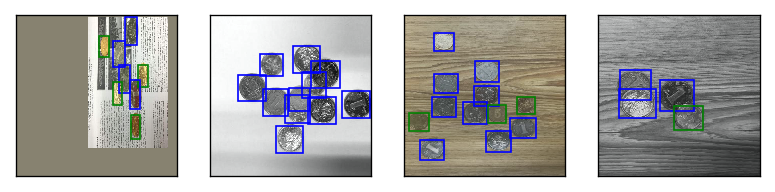

In [54]:
from utils.utils import show_det_results
from mxnet.contrib.ndarray import MultiBoxDetection

mpl.rcParams['figure.figsize'] = (6, 6)
try:
    batch = train_data.next()
except Exception:
    train_data.reset()
data = batch.data[0].as_in_context(ctx)
label = batch.label[0].as_in_context(ctx)
anchors, box_preds, cls_preds = net(data)
cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, 
                                                  cls_preds.transpose(axes=(0, 2, 1)), negative_mining_ratio=3)

imgs = (data.transpose((0, 2, 3, 1)).asnumpy() * std)+ rgb_mean
#plt.imshow(imgs[0] / 255)
show_det_results(imgs, out, threshold=0.4, show_text=False, MN=(2, 4))

## temp result note

### body_net_args=['vgg11bn', 15, True]
```
just change vgg11bn[:21] to vgg11bn[:15], AP down too much
epoch: 9 time: 2.43 loss: 0.9450, 0.1676 lr: 0.5000 train mae: 0.0123 AP: 0.4334 valid mae: 0.0139 AP: 0.4728
epoch: 19 time: 2.41 loss: 0.7989, 0.1384 lr: 0.5000 train mae: 0.0106 AP: 0.5849 valid mae: 0.0127 AP: 0.5412
epoch: 29 time: 2.42 loss: 0.8191, 0.1382 lr: 0.5000 train mae: 0.0110 AP: 0.6104 valid mae: 0.0112 AP: 0.6760
epoch: 39 time: 2.41 loss: 0.8193, 0.1322 lr: 0.5000 train mae: 0.0107 AP: 0.6309 valid mae: 0.0103 AP: 0.7360
epoch: 49 time: 2.54 loss: 0.6646, 0.1012 lr: 0.5000 train mae: 0.0084 AP: 0.6452 valid mae: 0.0098 AP: 0.7549
epoch: 59 time: 2.40 loss: 0.7016, 0.0998 lr: 0.5000 train mae: 0.0087 AP: 0.6784 valid mae: 0.0090 AP: 0.7336
epoch: 69 time: 2.47 loss: 0.6882, 0.0992 lr: 0.5000 train mae: 0.0086 AP: 0.6855 valid mae: 0.0093 AP: 0.7756
epoch: 79 time: 2.40 loss: 0.7329, 0.0992 lr: 0.5000 train mae: 0.0091 AP: 0.7399 valid mae: 0.0091 AP: 0.8072
epoch: 89 time: 2.41 loss: 0.6215, 0.0902 lr: 0.5000 train mae: 0.0081 AP: 0.6973 valid mae: 0.0086 AP: 0.7770
epoch: 99 time: 2.44 loss: 0.6760, 0.0985 lr: 0.5000 train mae: 0.0089 AP: 0.7023 valid mae: 0.0084 AP: 0.8078
epoch: 109 time: 2.42 loss: 0.6976, 0.0972 lr: 0.2500 train mae: 0.0088 AP: 0.7427 valid mae: 0.0081 AP: 0.8172
epoch: 119 time: 2.40 loss: 0.5613, 0.0777 lr: 0.2500 train mae: 0.0074 AP: 0.7460 valid mae: 0.0079 AP: 0.8290
epoch: 129 time: 2.38 loss: 0.7191, 0.0937 lr: 0.2500 train mae: 0.0089 AP: 0.7229 valid mae: 0.0080 AP: 0.8128
epoch: 139 time: 2.42 loss: 0.6040, 0.0796 lr: 0.2500 train mae: 0.0078 AP: 0.7509 valid mae: 0.0081 AP: 0.7826
epoch: 149 time: 2.43 loss: 0.6063, 0.0840 lr: 0.2500 train mae: 0.0079 AP: 0.7549 valid mae: 0.0079 AP: 0.8219
epoch: 159 time: 2.39 loss: 0.5913, 0.0840 lr: 0.1250 train mae: 0.0076 AP: 0.6954 valid mae: 0.0081 AP: 0.7934
epoch: 169 time: 2.43 loss: 0.5360, 0.0708 lr: 0.1250 train mae: 0.0069 AP: 0.7499 valid mae: 0.0079 AP: 0.8089
epoch: 179 time: 2.38 loss: 0.6168, 0.0817 lr: 0.1250 train mae: 0.0080 AP: 0.7695 valid mae: 0.0076 AP: 0.8150
epoch: 189 time: 2.49 loss: 0.5493, 0.0768 lr: 0.0625 train mae: 0.0075 AP: 0.7410 valid mae: 0.0077 AP: 0.8232
epoch: 199 time: 2.41 loss: 0.5184, 0.0728 lr: 0.0625 train mae: 0.0070 AP: 0.7408 valid mae: 0.0081 AP: 0.8023
```
### body_net_args=['vgg11bn', 21, True]
```
epoch: 9 time: 2.63 loss: 0.7887, 0.1551 lr: 0.5000 train mae: 0.0121 AP: 0.6730 valid mae: 0.0111 AP: 0.7188
epoch: 19 time: 2.65 loss: 0.6184, 0.1016 lr: 0.5000 train mae: 0.0092 AP: 0.7435 valid mae: 0.0077 AP: 0.8111
epoch: 29 time: 2.66 loss: 0.4258, 0.0699 lr: 0.5000 train mae: 0.0069 AP: 0.7423 valid mae: 0.0068 AP: 0.8475
epoch: 39 time: 2.61 loss: 0.4659, 0.0701 lr: 0.5000 train mae: 0.0071 AP: 0.7644 valid mae: 0.0066 AP: 0.8520
epoch: 49 time: 2.61 loss: 0.4440, 0.0647 lr: 0.5000 train mae: 0.0068 AP: 0.7680 valid mae: 0.0061 AP: 0.8453
epoch: 59 time: 2.63 loss: 0.3967, 0.0553 lr: 0.5000 train mae: 0.0061 AP: 0.7731 valid mae: 0.0058 AP: 0.8585
epoch: 69 time: 2.67 loss: 0.3973, 0.0537 lr: 0.5000 train mae: 0.0061 AP: 0.7995 valid mae: 0.0051 AP: 0.8571
epoch: 79 time: 2.65 loss: 0.3655, 0.0470 lr: 0.5000 train mae: 0.0055 AP: 0.7901 valid mae: 0.0060 AP: 0.8926
epoch: 89 time: 2.65 loss: 0.3336, 0.0470 lr: 0.5000 train mae: 0.0053 AP: 0.7733 valid mae: 0.0051 AP: 0.8720
epoch: 99 time: 2.64 loss: 0.3264, 0.0402 lr: 0.5000 train mae: 0.0051 AP: 0.7973 valid mae: 0.0048 AP: 0.8604
epoch: 109 time: 2.65 loss: 0.3059, 0.0361 lr: 0.2500 train mae: 0.0047 AP: 0.7997 valid mae: 0.0043 AP: 0.8976
epoch: 119 time: 2.65 loss: 0.2949, 0.0377 lr: 0.2500 train mae: 0.0047 AP: 0.7949 valid mae: 0.0046 AP: 0.8799
epoch: 129 time: 2.64 loss: 0.2862, 0.0383 lr: 0.2500 train mae: 0.0046 AP: 0.7980 valid mae: 0.0042 AP: 0.8786
epoch: 139 time: 2.63 loss: 0.2631, 0.0311 lr: 0.2500 train mae: 0.0041 AP: 0.8365 valid mae: 0.0042 AP: 0.8998
epoch: 149 time: 2.64 loss: 0.2772, 0.0361 lr: 0.2500 train mae: 0.0046 AP: 0.7952 valid mae: 0.0045 AP: 0.8976
epoch: 159 time: 2.67 loss: 0.3042, 0.0421 lr: 0.1250 train mae: 0.0052 AP: 0.8011 valid mae: 0.0040 AP: 0.8909
epoch: 169 time: 2.64 loss: 0.2784, 0.0359 lr: 0.1250 train mae: 0.0047 AP: 0.7961 valid mae: 0.0040 AP: 0.8978
epoch: 179 time: 2.65 loss: 0.2842, 0.0343 lr: 0.1250 train mae: 0.0044 AP: 0.7979 valid mae: 0.0038 AP: 0.8878
epoch: 189 time: 2.67 loss: 0.2463, 0.0308 lr: 0.0625 train mae: 0.0042 AP: 0.8098 valid mae: 0.0038 AP: 0.9017
epoch: 199 time: 2.64 loss: 0.2802, 0.0376 lr: 0.0625 train mae: 0.0048 AP: 0.8041 valid mae: 0.0038 AP: 0.9017
```

### body_net_args=['vgg11bn', 21, False]
小数据集上没有pretrain模型， AP值和mae，以及收敛稳定性会差好多，一个好的初始化方法效果会好很多。<br/>
这个道理和其他的启发式算法（如遗传算法）是一致的
```
epoch: 9 time: 2.76 loss: 0.9986, 0.1540 lr: 0.5000 train mae: 0.0119 AP: 0.5725 valid mae: 0.0126 AP: 0.4862
epoch: 19 time: 2.66 loss: 0.7719, 0.1098 lr: 0.5000 train mae: 0.0091 AP: 0.6593 valid mae: 0.0099 AP: 0.7385
epoch: 29 time: 2.67 loss: 0.7461, 0.0960 lr: 0.5000 train mae: 0.0086 AP: 0.6891 valid mae: 0.0090 AP: 0.7376
epoch: 39 time: 2.65 loss: 0.6935, 0.0953 lr: 0.5000 train mae: 0.0086 AP: 0.6833 valid mae: 0.0083 AP: 0.8036
epoch: 49 time: 2.64 loss: 0.6409, 0.0841 lr: 0.5000 train mae: 0.0082 AP: 0.7514 valid mae: 0.0075 AP: 0.8472
epoch: 59 time: 2.66 loss: 0.6589, 0.0830 lr: 0.5000 train mae: 0.0081 AP: 0.7212 valid mae: 0.0072 AP: 0.7635
epoch: 69 time: 2.65 loss: 0.5253, 0.0629 lr: 0.5000 train mae: 0.0062 AP: 0.7305 valid mae: 0.0080 AP: 0.8355
epoch: 79 time: 2.73 loss: 0.5477, 0.0638 lr: 0.5000 train mae: 0.0067 AP: 0.7582 valid mae: 0.0066 AP: 0.8195
epoch: 89 time: 2.81 loss: 0.5633, 0.0677 lr: 0.5000 train mae: 0.0072 AP: 0.7523 valid mae: 0.0063 AP: 0.8444
epoch: 99 time: 2.66 loss: 0.5253, 0.0580 lr: 0.5000 train mae: 0.0063 AP: 0.7631 valid mae: 0.0064 AP: 0.8499
epoch: 109 time: 2.64 loss: 0.4473, 0.0532 lr: 0.2500 train mae: 0.0059 AP: 0.7526 valid mae: 0.0065 AP: 0.8513
epoch: 119 time: 2.65 loss: 0.4417, 0.0566 lr: 0.2500 train mae: 0.0061 AP: 0.7600 valid mae: 0.0065 AP: 0.8304
epoch: 129 time: 2.66 loss: 0.4723, 0.0533 lr: 0.2500 train mae: 0.0060 AP: 0.7531 valid mae: 0.0056 AP: 0.8758
epoch: 139 time: 2.65 loss: 0.3927, 0.0417 lr: 0.2500 train mae: 0.0051 AP: 0.7872 valid mae: 0.0057 AP: 0.8448
epoch: 149 time: 2.74 loss: 0.4123, 0.0492 lr: 0.2500 train mae: 0.0055 AP: 0.7800 valid mae: 0.0058 AP: 0.8545
```
```
epoch: 9 time: 2.74 loss: 1.0503, 0.1599 lr: 0.5000 train mae: 0.0121 AP: 0.5149 valid mae: 0.0124 AP: 0.5147
epoch: 19 time: 2.67 loss: 0.9356, 0.1338 lr: 0.5000 train mae: 0.0107 AP: 0.6256 valid mae: 0.0101 AP: 0.7661
epoch: 29 time: 2.73 loss: 0.7659, 0.1116 lr: 0.5000 train mae: 0.0095 AP: 0.6771 valid mae: 0.0094 AP: 0.7286
epoch: 39 time: 2.79 loss: 0.6120, 0.0845 lr: 0.5000 train mae: 0.0077 AP: 0.6728 valid mae: 0.0085 AP: 0.7133
epoch: 49 time: 2.88 loss: 0.6536, 0.0835 lr: 0.5000 train mae: 0.0076 AP: 0.6488 valid mae: 0.0077 AP: 0.7995
epoch: 59 time: 2.95 loss: 0.6888, 0.0937 lr: 0.5000 train mae: 0.0087 AP: 0.6790 valid mae: 0.0076 AP: 0.7827
epoch: 69 time: 2.76 loss: 0.5947, 0.0746 lr: 0.5000 train mae: 0.0074 AP: 0.7395 valid mae: 0.0085 AP: 0.7359
epoch: 79 time: 2.80 loss: 0.5222, 0.0673 lr: 0.5000 train mae: 0.0067 AP: 0.7098 valid mae: 0.0060 AP: 0.8494
epoch: 89 time: 2.80 loss: 0.5226, 0.0592 lr: 0.5000 train mae: 0.0063 AP: 0.7311 valid mae: 0.0061 AP: 0.8536
epoch: 99 time: 2.71 loss: 0.4792, 0.0564 lr: 0.5000 train mae: 0.0060 AP: 0.7572 valid mae: 0.0070 AP: 0.7754
epoch: 109 time: 2.71 loss: 0.4732, 0.0527 lr: 0.2500 train mae: 0.0061 AP: 0.7837 valid mae: 0.0060 AP: 0.8054
epoch: 119 time: 2.80 loss: 0.4314, 0.0490 lr: 0.2500 train mae: 0.0057 AP: 0.7776 valid mae: 0.0052 AP: 0.8657
epoch: 129 time: 2.68 loss: 0.3881, 0.0449 lr: 0.2500 train mae: 0.0048 AP: 0.7532 valid mae: 0.0052 AP: 0.8656
epoch: 139 time: 2.70 loss: 0.4050, 0.0464 lr: 0.2500 train mae: 0.0056 AP: 0.7851 valid mae: 0.0048 AP: 0.8777
epoch: 149 time: 2.67 loss: 0.4148, 0.0470 lr: 0.2500 train mae: 0.0053 AP: 0.7591 valid mae: 0.0064 AP: 0.8493
epoch: 159 time: 2.68 loss: 0.3285, 0.0400 lr: 0.1250 train mae: 0.0045 AP: 0.7546 valid mae: 0.0048 AP: 0.8729
epoch: 169 time: 2.66 loss: 0.3789, 0.0460 lr: 0.1250 train mae: 0.0053 AP: 0.7581 valid mae: 0.0046 AP: 0.8792
epoch: 179 time: 2.68 loss: 0.3796, 0.0430 lr: 0.1250 train mae: 0.0051 AP: 0.7667 valid mae: 0.0046 AP: 0.8809
epoch: 189 time: 3.07 loss: 0.3803, 0.0459 lr: 0.0625 train mae: 0.0057 AP: 0.7923 valid mae: 0.0046 AP: 0.8530
epoch: 199 time: 2.73 loss: 0.3391, 0.0379 lr: 0.0625 train mae: 0.0047 AP: 0.7820 valid mae: 0.0046 AP: 0.8839
```

### body_net_args=['vgg11bn', 28, True]
```
epoch: 9 time: 2.74 loss: 0.6761, 0.1228 lr: 0.5000 train mae: 0.0105 AP: 0.7676 valid mae: 0.0079 AP: 0.8533
epoch: 19 time: 2.61 loss: 0.4456, 0.0816 lr: 0.5000 train mae: 0.0077 AP: 0.7821 valid mae: 0.0064 AP: 0.8705
epoch: 29 time: 2.61 loss: 0.4270, 0.0760 lr: 0.5000 train mae: 0.0074 AP: 0.7920 valid mae: 0.0054 AP: 0.8967
epoch: 39 time: 2.60 loss: 0.4015, 0.0616 lr: 0.5000 train mae: 0.0066 AP: 0.7991 valid mae: 0.0052 AP: 0.9031
epoch: 49 time: 2.55 loss: 0.3522, 0.0491 lr: 0.5000 train mae: 0.0060 AP: 0.8056 valid mae: 0.0052 AP: 0.8949
epoch: 59 time: 2.55 loss: 0.3668, 0.0532 lr: 0.5000 train mae: 0.0060 AP: 0.7997 valid mae: 0.0047 AP: 0.9015
epoch: 69 time: 2.73 loss: 0.3507, 0.0491 lr: 0.5000 train mae: 0.0058 AP: 0.7927 valid mae: 0.0046 AP: 0.9000
epoch: 79 time: 2.56 loss: 0.3307, 0.0414 lr: 0.5000 train mae: 0.0055 AP: 0.7948 valid mae: 0.0037 AP: 0.8998
epoch: 89 time: 2.58 loss: 0.2929, 0.0371 lr: 0.5000 train mae: 0.0047 AP: 0.7944 valid mae: 0.0036 AP: 0.9015
epoch: 99 time: 2.55 loss: 0.3012, 0.0383 lr: 0.5000 train mae: 0.0051 AP: 0.7836 valid mae: 0.0035 AP: 0.9032
epoch: 109 time: 2.57 loss: 0.2708, 0.0350 lr: 0.2500 train mae: 0.0043 AP: 0.7828 valid mae: 0.0035 AP: 0.9018
epoch: 119 time: 2.62 loss: 0.2730, 0.0318 lr: 0.2500 train mae: 0.0042 AP: 0.7738 valid mae: 0.0034 AP: 0.8897
epoch: 129 time: 2.57 loss: 0.2900, 0.0324 lr: 0.2500 train mae: 0.0048 AP: 0.7800 valid mae: 0.0033 AP: 0.9062
epoch: 139 time: 2.56 loss: 0.2752, 0.0287 lr: 0.2500 train mae: 0.0046 AP: 0.7772 valid mae: 0.0033 AP: 0.9076
epoch: 149 time: 2.57 loss: 0.2732, 0.0299 lr: 0.2500 train mae: 0.0044 AP: 0.7934 valid mae: 0.0031 AP: 0.9076
epoch: 159 time: 2.55 loss: 0.2647, 0.0343 lr: 0.1250 train mae: 0.0046 AP: 0.7800 valid mae: 0.0031 AP: 0.9062
epoch: 169 time: 2.58 loss: 0.2640, 0.0276 lr: 0.1250 train mae: 0.0045 AP: 0.8012 valid mae: 0.0029 AP: 0.9062
epoch: 179 time: 2.55 loss: 0.2241, 0.0230 lr: 0.1250 train mae: 0.0036 AP: 0.7834 valid mae: 0.0029 AP: 0.9062
epoch: 189 time: 2.58 loss: 0.2395, 0.0243 lr: 0.0625 train mae: 0.0038 AP: 0.7900 valid mae: 0.0029 AP: 0.9062
epoch: 199 time: 2.56 loss: 0.2316, 0.0220 lr: 0.0625 train mae: 0.0036 AP: 0.7834 valid mae: 0.0029 AP: 0.9076
```


### body_net_args=['mobilenet_1_0', 33, False]
```
epoch: 9 time: 2.07 loss: 1.0970, 0.1725 lr: 0.5000 train mae: 0.0126 AP: 0.4972 valid mae: 0.0137 AP: 0.5101
epoch: 19 time: 2.04 loss: 0.8662, 0.1339 lr: 0.5000 train mae: 0.0105 AP: 0.6233 valid mae: 0.0115 AP: 0.6067
epoch: 29 time: 2.03 loss: 0.8702, 0.1277 lr: 0.5000 train mae: 0.0107 AP: 0.6586 valid mae: 0.0103 AP: 0.7869
epoch: 39 time: 2.03 loss: 0.9056, 0.1265 lr: 0.5000 train mae: 0.0108 AP: 0.6919 valid mae: 0.0096 AP: 0.7948
epoch: 49 time: 2.05 loss: 0.7214, 0.0952 lr: 0.5000 train mae: 0.0086 AP: 0.6916 valid mae: 0.0092 AP: 0.5420
epoch: 59 time: 2.04 loss: 0.5800, 0.0786 lr: 0.5000 train mae: 0.0072 AP: 0.7123 valid mae: 0.0098 AP: 0.6899
epoch: 69 time: 2.20 loss: 0.5814, 0.0819 lr: 0.5000 train mae: 0.0074 AP: 0.6730 valid mae: 0.0087 AP: 0.8267
epoch: 79 time: 2.02 loss: 0.6429, 0.0816 lr: 0.5000 train mae: 0.0076 AP: 0.6986 valid mae: 0.0108 AP: 0.6464
epoch: 89 time: 2.03 loss: 0.6797, 0.0770 lr: 0.5000 train mae: 0.0073 AP: 0.7215 valid mae: 0.0092 AP: 0.5878
epoch: 99 time: 2.13 loss: 0.6217, 0.0843 lr: 0.5000 train mae: 0.0081 AP: 0.7410 valid mae: 0.0108 AP: 0.5999
epoch: 109 time: 2.07 loss: 0.5211, 0.0590 lr: 0.2500 train mae: 0.0061 AP: 0.7335 valid mae: 0.0147 AP: 0.6561
epoch: 119 time: 2.01 loss: 0.5428, 0.0647 lr: 0.2500 train mae: 0.0066 AP: 0.7535 valid mae: 0.0076 AP: 0.8520
epoch: 129 time: 2.07 loss: 0.6395, 0.0718 lr: 0.2500 train mae: 0.0074 AP: 0.7401 valid mae: 0.0077 AP: 0.7582
epoch: 139 time: 2.03 loss: 0.4948, 0.0616 lr: 0.2500 train mae: 0.0062 AP: 0.7530 valid mae: 0.0072 AP: 0.8033
epoch: 149 time: 2.03 loss: 0.5496, 0.0661 lr: 0.2500 train mae: 0.0069 AP: 0.7401 valid mae: 0.0087 AP: 0.7462
epoch: 159 time: 2.03 loss: 0.4935, 0.0582 lr: 0.1250 train mae: 0.0062 AP: 0.7473 valid mae: 0.0070 AP: 0.6956
epoch: 169 time: 2.06 loss: 0.5057, 0.0603 lr: 0.1250 train mae: 0.0063 AP: 0.7660 valid mae: 0.0063 AP: 0.8206
epoch: 179 time: 2.04 loss: 0.4568, 0.0550 lr: 0.1250 train mae: 0.0057 AP: 0.7455 valid mae: 0.0094 AP: 0.6862
epoch: 189 time: 2.03 loss: 0.4575, 0.0537 lr: 0.0625 train mae: 0.0059 AP: 0.7465 valid mae: 0.0069 AP: 0.6832
epoch: 199 time: 2.01 loss: 0.5747, 0.0689 lr: 0.0625 train mae: 0.0072 AP: 0.7400 valid mae: 0.0074 AP: 0.6344
```